# Classify positive/negative reviews
----

This notebook shows an example to classify text reviews from IMDB ([Internet Movie DataBase](https://www.imdb.com/)) are positive or negative review. This notebook is taken and modified from the [TensorFlow guide](https://www.tensorflow.org/tutorials/keras/basic_text_classification).

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

import sys
sys.path.append('..')
from datasets import imdb

print(tf.__version__)

1.11.0


The dataset comes from the TensorFlow package and it has been pre-processed that the reviews (sequence of words) have been converted into unique integers for each word. Labels are either 0 (negative review) or 1 (positive review).

### Create new reserved keywords

Each sample contains a text that can be any number of words, but the network needs a fixed number of elements for each sample. Therefore, we need to somehow pad them with a unique reserved index (not a word).

We need to create new indices for some non-word items: *pad*, *start*, *unknown* and *unused*.

In [2]:
# load word dictionary for adding some new keywords
word_dict = imdb.load_word_index()

# shift the first four indices
word_dict = {k:(v+3) for (k,v) in word_dict.items()}

# make the first four indices to our new reserved non-word items
word_dict['<PAD>'] = 0
word_dict['<START>'] = 1
word_dict['<UNKNOWN>'] = 2
word_dict['<UNUSED>'] = 3

### Make the number of elements from all samples equal

Load the data and pad each sample with the new `<PAD>` keywords at the end.

In [3]:
# To make the size manageable, we filter the top 10,000 most frequent words in the training data.
# Hence, rare words are not being trained.
num_words = 10000

# maximum length of the review for each sample
# use None for getting to max, but that may create different size between training & test data
max_sample = 256

# load the data
(train_data, train_labels), (test_data, test_labels) = imdb.load(num_words=num_words)

# pad training and test data with <PAD> at the end of each sample, 
# such that all samples have equal number of elements

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value = word_dict['<PAD>'],
                                                       padding = 'post',
                                                       maxlen = max_sample)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value = word_dict['<PAD>'],
                                                       padding = 'post',
                                                       maxlen = max_sample)

# let's print the shape of our data
print("Training: data = {}, labels = {}".format(train_data.shape, train_labels.shape))
print("Test:     data = {}, labels = {}".format(test_data.shape, test_labels.shape))

Training: data = (25000, 256), labels = (25000,)
Test:     data = (25000, 256), labels = (25000,)


### Visualize the data

We can create a function to decode the word indices and print the original text of the review.

In [4]:
# get reverse word indices based on our modified word indices
rev_word_index = imdb.get_rev_word_index(word_dict)

def decode_review(indices):
    return " ".join([rev_word_index[i] for i in indices if i>3]).strip()

# test one
decode_review(train_data[100])

"i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10"

## Building the network
----

The input data is an array of integers (word indices). The labels are 0 or 1. The first layer to create is an *embedding layer*, which creates a dense vector from the sparsed word indices. The dense vectors are learned during training.

For example, if the sentence is "deep learning is really deep to learn", then the word indices are: `[0 1 2 3 1 4 5]`, where the dictionary is
```
[0, deep]
[1, learning]
[2, is]
[3, really]
[4, to]
[5, learn]
```
The embedding layer transform it into a real value vector of `D` dimension for each index. The size of `D` is free to choose. Hence, embedding layer actually converts discrete space input into continuous domain.

At the beginning, the values of these vectors are chosen randomly. During the training, the network will learn, and it is usually based on the words adjacent to it, distance or nearest neighbor. 

Layers are:

* [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) with size of `feature_dim`.
* [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) to take the average value of the embedded vector, 
* [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), a fully connected layer from `feature_dim` neurons with [relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu) activation, and 
* The final [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with [sigmoid](https://www.tensorflow.org/api_docs/python/tf/nn/relu) function for classification.

In [5]:
feature_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, feature_dim))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(feature_dim, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


Let's compile the model with [Adam optmizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) and `binary_crossentropy` loss function. This loss function calculates the distance betweent two probability distribution functions, which is suitable for this classification problem.

In [6]:
model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training the model
----

Usually the training data is split into into training & validation set, randomly. Just to make it easier, we split the first 10000 samples as our validation data, and the model is trained on the remaining ones.

In [7]:
history = model.fit(
    train_data[10000:],
    train_labels[10000:],
    epochs=40,
    batch_size=512,
    validation_data=(train_data[:10000], train_labels[:10000]),
    verbose=1
)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 89us/step - loss: 0.6921 - acc: 0.5801 - val_loss: 0.6903 - val_acc: 0.6839
Epoch 2/40
15000/15000 [==============================] - 1s 64us/step - loss: 0.6864 - acc: 0.7067 - val_loss: 0.6817 - val_acc: 0.6724
Epoch 3/40
15000/15000 [==============================] - 1s 67us/step - loss: 0.6728 - acc: 0.7275 - val_loss: 0.6639 - val_acc: 0.7256
Epoch 4/40
15000/15000 [==============================] - 1s 73us/step - loss: 0.6478 - acc: 0.7411 - val_loss: 0.6357 - val_acc: 0.7706
Epoch 5/40
15000/15000 [==============================] - 1s 69us/step - loss: 0.6110 - acc: 0.7910 - val_loss: 0.5967 - val_acc: 0.7833
Epoch 6/40
15000/15000 [==============================] - 1s 68us/step - loss: 0.5652 - acc: 0.8153 - val_loss: 0.5529 - val_acc: 0.7977
Epoch 7/40
15000/15000 [==============================] - 1s 62us/step - loss: 0.5151 - acc: 0.8374 - val_loss: 0.5073 - val_acc

## Evaluate the model
----
Using test data, which are not seen during the training, we can evaluate our model

In [8]:
results = model.evaluate(x = test_data, y = test_labels)

print(results)

25000/25000 [==============================] - 1s 37us/step
[0.3368314883327484, 0.87208]


Plot the training accuracy and error from the `history`

Text(0.5, 1.0, 'Loss (error)')

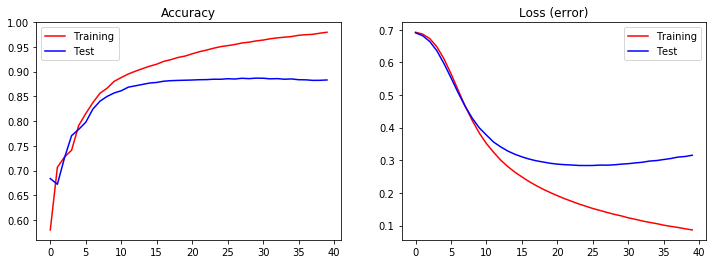

In [9]:
# get the metrics from history
h = history.history

plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
ax1.plot(h['acc'],'r', label='Training')
ax1.plot(h['val_acc'],'b', label='Test')
ax1.legend()
ax1.set_title('Accuracy')

ax2 = plt.subplot(122)
ax2.plot(h['loss'],'r', label='Training')
ax2.plot(h['val_loss'],'b', label='Test')
ax2.legend()
ax2.set_title('Loss (error)')

There is clearly of *overtraining* after 20 epochs.